In [4]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [5]:
IMAGE_SHAPE = (256, 256)
BATCH_SIZE = 32

In [6]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    shuffle=True,
    image_size=IMAGE_SHAPE,
    batch_size=BATCH_SIZE,
)

Found 2152 files belonging to 3 classes.


# Exploring Images

## Getting class names

In [9]:
dataset.class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

## Showing 10 images

(32, 256, 256, 3)
tf.Tensor([1 2 0 0 0 0 0 2 1 0 0 0 1 2 1 0 0 1 1 1 1 1 1 0 0 1 1 0 1 1 1 0], shape=(32,), dtype=int32)


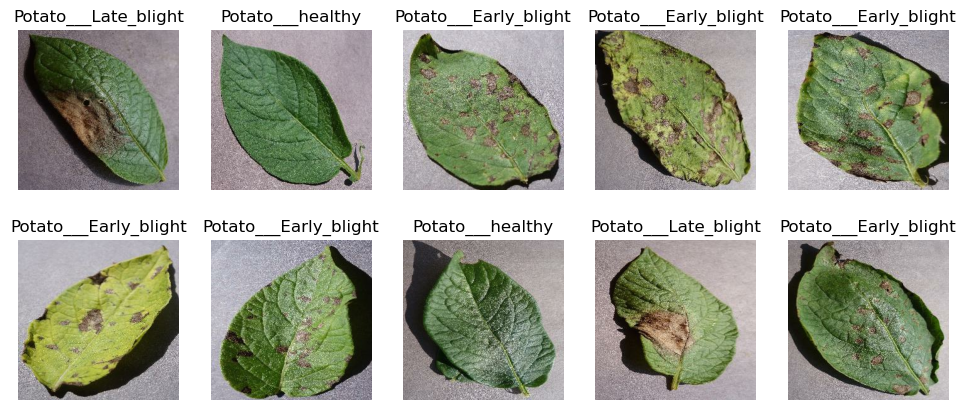

In [28]:
plt.figure(figsize=(12, 5))

for image_batch, label_batch in dataset.take(1):

    print(image_batch.shape)
    print(label_batch)

    for i in range(10):
        ax = plt.subplot(2, 5, i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(dataset.class_names[label_batch[i]])
        plt.axis(False)

# Preparing Data

## Splitting

In [52]:
def split_dataset(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10_000):
    dataset_size = len(ds)

    # Calculating number of batch samples to take for each dataset
    train_dataset_size = round(dataset_size * train_split)
    val_dataset_size = round(val_split * len(dataset))
    test_dataset_size = round(test_split * len(dataset))

    # Getting training data from dataset
    train_data = dataset.take(train_dataset_size)

    # Getting validation and testing data from batch
    temp_data = dataset.skip(train_dataset_size)
    val_data = temp_data.take(val_dataset_size)
    test_data = temp_data.skip(val_dataset_size).take(test_dataset_size)

    if shuffle:
        train_data = train_data.cache().shuffle(shuffle_size).prefetch(buffer_size=tf.data.AUTOTUNE)
        val_data = val_data.cache().shuffle(shuffle_size).prefetch(buffer_size=tf.data.AUTOTUNE)
        test_data = test_data.cache().shuffle(shuffle_size).prefetch(buffer_size=tf.data.AUTOTUNE)
        print("Dataset cached.")

    print(f"Splitted dataset with length {dataset_size} into {train_dataset_size} Training Data, {val_dataset_size} Validation Data, {test_dataset_size} Test Data.")

    return train_data, val_data, test_data

In [53]:
train_data, val_data, test_data = split_dataset(dataset)

Dataset cached.
Splitted dataset with length 68 into 54 Training Data, 7 Validation Data, 7 Test Data.


## Preprocessing

In [54]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SHAPE[0], IMAGE_SHAPE[1]),
    layers.experimental.preprocessing.Rescaling(1.0/255),
])

# Data Augmentation

In [56]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2),
])

# Training

In [45]:
TRAINING_EPOCHS = 50